In [ ]:
!pip install langchain
!pip install openai
!pip install langchain-community langchain
!pip install langgraph
!pip install -U langchain langchain-openai

In [79]:
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, END, START
from operator import add

##Annotated with Integers: Simple Counter

In [62]:
class MyState(TypedDict):
  attempts: Annotated[int, add]
  # The 'add' operator here tells LangGraph to add a new integer value
  # to the existing 'attempts' value, rather than overwriting it.

In [63]:
def run_task(state: MyState)-> MyState:
  print("Running Task.......")

  return {"attempts": 1}
  # This node returns 1, which will be added to the attempts count.

def check_attempts(state:MyState)->str:
  print("Task number:", state['attempts'])
  if state["attempts"]>3:
    print("Task failed after 3 attempts.")
    return 'end'
  else:
    print("Retrying task...")
    return 'continue'

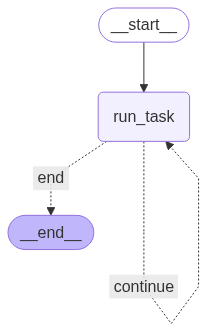

In [64]:
graph = StateGraph(MyState)

graph.add_node('run_task', run_task)
graph.add_edge(START, 'run_task')
graph.add_conditional_edges(
    'run_task',
    check_attempts,
    {
        'end':END,
        'continue':'run_task'
    })

graph.compile()


In [65]:
app = graph.compile()

In [66]:
app.invoke({'attempts':0})

Running Task.......
Task number: 1
Retrying task...
Running Task.......
Task number: 2
Retrying task...
Running Task.......
Task number: 3
Retrying task...
Running Task.......
Task number: 4
Task failed after 3 attempts.


{'attempts': 4}

##Annotated with string

In [25]:
import operator

In [36]:
class StatusState(TypedDict):
  status_log: Annotated[str,operator.concat]

In [40]:
def start_process(state:StatusState)-> StatusState:
  return {'status_log': 'Process Started....\n'}

def perform_step_one(state: StatusState) -> StatusState:
    return {"status_log": "Step 1 completed.\n"}

def perform_step_two(state: StatusState) -> StatusState:
    return {"status_log": "Step 2 completed.\n"}

def finalize_process(state: StatusState) -> StatusState:
    return {"status_log": "Process finalized.\n"}

In [41]:
# Build the graph
workflow = StateGraph(StatusState)
workflow.add_node("start", start_process)
workflow.add_node("step_one", perform_step_one)
workflow.add_node("step_two", perform_step_two)
workflow.add_node("finalize", finalize_process)

workflow.add_edge(START, "step_one")
workflow.add_edge("step_one", "step_two")
workflow.add_edge("step_two", "finalize")
workflow.add_edge("finalize", END)
workflow.set_entry_point("start")

app = workflow.compile()

In [42]:
app.invoke({'status_log':""})

{'status_log': 'Process Started....\nStep 1 completed.\nStep 2 completed.\nProcess finalized.\n'}

##Annotated with HumanMessage and AIMessage

In [43]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

In [75]:
class AgentState(TypedDict):
  messages: Annotated[list[BaseMessage], add_messages]
  # The `add_messages` function is a special reducer.
  # Instead of overwriting the 'messages' list, it appends new messages to it.

In [76]:
def add_human_message(state: AgentState)-> AgentState:
    new_message = HumanMessage(content="Hello how are you?")
    return {'messages':[new_message]}

def add_ai_message(state: AgentState)-> AgentState:
    new_message = AIMessage(content="I am a bot Jarvis. How can I assist you today?")
    return {'messages':[new_message]}

In [77]:
# Build the graph
workflow = StateGraph(AgentState)
workflow.add_node("human", add_human_message)
workflow.add_node("AI", add_ai_message)


workflow.add_edge(START, "human")
workflow.add_edge("human","AI")
workflow.add_edge("AI", END)


app = workflow.compile()

In [78]:
app.invoke({"messages":[]})

{'messages': [HumanMessage(content='Hello how are you?', additional_kwargs={}, response_metadata={}, id='a363a43c-3e69-424a-a1be-0d8f154efdda'),
  AIMessage(content='I am a bot Jarvis. How can I assist you today?', additional_kwargs={}, response_metadata={}, id='e981f67c-52cc-47b1-94da-51d8a54325cb')]}

##Integrated Example: AI & Human Messages with Status and a Counter

In [83]:
class IntegratedState(TypedDict):
  messages: Annotated[List[BaseMessage],add_messages]
  attempts: Annotated[int,add]
  status:Annotated[str,add]

In [84]:
def initial_ai_response(state: IntegratedState)-> IntegratedState:
  print('AI first response')
  ai_message = AIMessage(content="Hi, this is first attempt to solve the problem")
  return {
      'messages': ai_message,
      'attempts':1,
      'status': "Initial Attempt\n"
      }

# Node 2: A conditional router that checks attempts and the user's response
def should_continue_or_escalate(state: IntegratedState) -> str:
    current_attempts = state.get("attempts", 0)

    # Get the last message from the user
    #last_user_message = next((msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    last_user_message = None
    # Iterate through the messages in reverse order (from most recent to oldest)
    for msg in reversed(state["messages"]):
        # Check if the current message is a HumanMessage
        if isinstance(msg, HumanMessage):
            # If it is, store it and stop searching (we found the most recent one)
            last_user_message = msg
            break

    # If we've hit the attempt limit or the user's message indicates failure, escalate.
    if current_attempts >= 3 or (last_user_message and "didn't work" in last_user_message.content.lower()):
        return "escalate_to_human"
    else:
        return "retry_with_ai"

# Node 3: The AI retries the task
def retry_with_ai(state: IntegratedState) -> IntegratedState:
    ai_msg = AIMessage(content=f"Attempt {state['attempts'] + 1} to solve the problem.")
    print(f"AI: {ai_msg.content}")
    return {"messages": [ai_msg], "attempts": 1, "status": f"Attempt {state['attempts'] + 1} in progress.\n"}

# Node 4: The human escalation node (a simple print statement for demonstration)
def escalate_to_human(state: IntegratedState) -> IntegratedState:
    human_escalation_msg = HumanMessage(content="Escalating the problem to a human expert.")
    print(f"Agent: {human_escalation_msg.content}")
    return {"messages": [human_escalation_msg], "status": "Problem escalated.\n"}

In [85]:
# Build the graph
workflow = StateGraph(IntegratedState)
workflow.add_node("initial_ai_response", initial_ai_response)
workflow.add_node("retry_with_ai", retry_with_ai)
workflow.add_node("escalate_to_human", escalate_to_human)

workflow.add_edge("initial_ai_response", "retry_with_ai")
workflow.add_conditional_edges("retry_with_ai", should_continue_or_escalate, {
    "retry_with_ai": "retry_with_ai",
    "escalate_to_human": "escalate_to_human"
})
workflow.add_edge("escalate_to_human", END)
workflow.set_entry_point("initial_ai_response")

app = workflow.compile()

# Example 1: The AI successfully solves the problem within 3 attempts.
# The user's input would be a message like "Thank you, that worked!"
# To simulate this, we would use a different router or break the loop.

# Example 2: The AI fails and escalates after a few attempts.
# The `invoke` call would be a series of messages from the user like "That didn't work."
final_state = app.invoke({"messages": [HumanMessage(content="My system is not working.")], "attempts": 0, "status": "Problem received.\n"})

# In a real application, the `invoke` call would be iterative with user input.
# This example simplifies it to show the conditional routing logic.

AI first response
AI: Attempt 2 to solve the problem.
AI: Attempt 3 to solve the problem.
Agent: Escalating the problem to a human expert.
